In [129]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [130]:
%cd /content/drive/MyDrive/PD_ML/project2

/content/drive/MyDrive/PD_ML/project2


In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 글꼴깨짐 방지
import matplotlib
import matplotlib.font_manager as fm

import warnings

# 경고 메시지를 무시하고 숨기거나
warnings.filterwarnings(action='ignore')

from sklearn.model_selection import train_test_split

import torch
import torch.optim as optim

In [132]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent 

In [133]:
dataset = pd.read_csv('train.csv')

In [134]:
def preprocessing(df):
    # 오류 단지코드가 존재하는 행들을  사전에 제거
    df_error =  ['C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988']
    #df_error =  ['C2335', 'C1327']
    df = df[~df['단지코드'].isin(df_error)].reset_index(drop=True)
    df.rename(columns = {'도보 10분거리 내 지하철역 수(환승노선 수 반영)':'지하철','도보 10분거리 내 버스정류장 수':'버스'},inplace=True)
    df.drop(columns=['임대보증금','임대료','자격유형','임대건물구분'],axis = 1,inplace=True)
    지역_비율 = (df.groupby(['지역'])['총세대수'].count())/(df.groupby(['지역'])['총세대수'].count().sum())*100
    지역_비율=지역_비율.reset_index(name='지역_비율')
    공급유형_비율 = (df.groupby(['공급유형'])['총세대수'].count())/(df.groupby(['공급유형'])['총세대수'].count().sum())*100
    공급유형_비율=공급유형_비율.reset_index(name='공급유형_비율')
    df = pd.merge(df,지역_비율, on='지역')
    df = pd.merge(df,공급유형_비율, on='공급유형')
    df.drop(columns=['지역','공급유형','단지코드'],axis = 1,inplace=True)
    df=df.dropna(axis=0)
    df = df[['총세대수', '전용면적', '전용면적별세대수', '공가수', '지하철', '버스', '단지내주차면수', '공급유형_비율',
       '지역_비율', '등록차량수']]
    return df

In [135]:
dataset = preprocessing(dataset)

In [136]:
import torch

# import 1D convolutional layer
from torch.nn import Conv1d

# import max pooling layer
from torch.nn import MaxPool1d

# import the flatten layer 
from torch.nn import Flatten

# import linear layer
from torch.nn import Linear

# import activation function (ReLU)
from torch.nn.functional import relu

# import libraries required for working with dataset from pytorch
from torch.utils.data import DataLoader, TensorDataset

In [137]:
# defined model named as CnnRegressor and
# this model should be the subclass of torch.nn.Module 
class CnnRegressor(torch.nn.Module):
  # defined the initialization method
  def __init__(self, batch_size, inputs, outputs):
    # initialization of the superclass
    super(CnnRegressor, self).__init__()
    # store the parameters
    self.batch_size = batch_size
    self.inputs = inputs
    self.outputs = outputs
    # define the input layer
    self.input_layer = Conv1d(inputs, batch_size, 1, stride = 1)
   
    # define max pooling layer
    self.max_pooling_layer = MaxPool1d(1)

    # define other convolutional layers
    self.conv_layer1 = Conv1d(batch_size, 128, 1, stride = 3)
    self.conv_layer2 = Conv1d(128, 256, 1, stride = 3)
    self.conv_layer3 = Conv1d(256, 512, 1, stride = 3)

    # define the flatten layer
    self.flatten_layer = Flatten()

    # define the linear layer
    self.linear_layer = Linear(512, 128)

    # define the output layer
    self.output_layer = Linear(128, outputs)

  # define the method to feed the inputs to the model
  def feed(self, input):
    # input is reshaped to the 1D array and fed into the input layer
    input = input.reshape((self.batch_size, self.inputs, 1))

    # ReLU is applied on the output of input layer
    output = relu(self.input_layer(input))

    # max pooling is applied and then Convolutions are done with ReLU
    output = self.max_pooling_layer(output)
    output = relu(self.conv_layer1(output))

    output = self.max_pooling_layer(output)
    output = relu(self.conv_layer2(output))

    output = self.max_pooling_layer(output)
    output = relu(self.conv_layer3(output))

    # flatten layer is applied
    output = self.flatten_layer(output)

    # linear layer and ReLu is applied
    output = relu(self.linear_layer(output))

    # finally, output layer is applied
    output = self.output_layer(output)
    return output

In [138]:
# import SGD for optimizer
from torch.optim import SGD

# import Adam for optimizer
from torch.optim import Adam

# to measure the performance import L1Loss
from torch.nn import L1Loss

# install pytorch's ignite and then import R2 score package
!pip install pytorch-ignite
from ignite.contrib.metrics.regression.r2_score import R2Score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [139]:
X = dataset.iloc[:, 1:-1].to_numpy()
y = dataset.iloc[:,-1].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [140]:
# define the batch size  
batch_size = 100
model = CnnRegressor(batch_size, X.shape[1], 1)

# we are using GPU so we have to set the model for that
model.cuda()

CnnRegressor(
  (input_layer): Conv1d(8, 100, kernel_size=(1,), stride=(1,))
  (max_pooling_layer): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv_layer1): Conv1d(100, 128, kernel_size=(1,), stride=(3,))
  (conv_layer2): Conv1d(128, 256, kernel_size=(1,), stride=(3,))
  (conv_layer3): Conv1d(256, 512, kernel_size=(1,), stride=(3,))
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (linear_layer): Linear(in_features=512, out_features=128, bias=True)
  (output_layer): Linear(in_features=128, out_features=1, bias=True)
)

In [141]:
def model_loss(model, dataset, train = False, optimizer = None):
  # first calculated for the batches and at the end get the average
  performance = L1Loss()
  score_metric = R2Score()

  avg_loss = 0
  avg_score = 0
  count = 0

  for input, output in iter(dataset):
    # get predictions of the model for training set
    predictions = model.feed(input)

    # calculate loss of the model
    loss = performance(predictions, output)

    # compute the R2 score
    score_metric.update([predictions, output])
    score = score_metric.compute()

    if(train):
      # clear the errors
      optimizer.zero_grad()

      # compute the gradients for optimizer
      loss.backward()

      # use optimizer in order to update parameters
      # of the model based on gradients
      optimizer.step()

    # store the loss and update values
    avg_loss += loss.item()
    avg_score += score
    count += 1

  return avg_loss/count, avg_score/count

In [162]:
# define the number of epochs
epochs = 100

# define the performance measure and optimizer
# optimizer = SGD( model.parameters(), lr= 1e-5)
optimizer = Adam(model.parameters())
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=0)

# to process with GPU, training set is converted into torch variable
inputs = torch.from_numpy(X_train).cuda().float()
outputs = torch.from_numpy(y_train.reshape(y_train.shape[0],1)).cuda().float()

# create the DataLoader instance to work with batches
tensor = TensorDataset(inputs, outputs)
loader = DataLoader(tensor, batch_size, shuffle = True, drop_last = True)


loss_list = []
r2_list = []

# loop for number of epochs and calculate average loss
for epoch in range(epochs):
   # model is cycled through the batches
  avg_loss, avg_r2_score = model_loss(model, loader, train = True, optimizer = optimizer)
  print("Epoch " + str(epoch + 1) + ":\n\tLoss = " + str(avg_loss) + "\n\tR^2 Score = " + str(avg_r2_score))
  loss_list.append(avg_loss)
  r2_list.append(avg_r2_score)

Epoch 1:
	Loss = 527.1439557756696
	R^2 Score = -1.9333971197389548
Epoch 2:
	Loss = 208.4740745907738
	R^2 Score = 0.29685054278256284
Epoch 3:
	Loss = 163.07098606654577
	R^2 Score = 0.6650515584877116
Epoch 4:
	Loss = 158.79049682617188
	R^2 Score = 0.7030836419850217
Epoch 5:
	Loss = 152.8808121454148
	R^2 Score = 0.7245779216178352
Epoch 6:
	Loss = 151.20064835321335
	R^2 Score = 0.7020592910925456
Epoch 7:
	Loss = 150.58685775030227
	R^2 Score = 0.717131810625307
Epoch 8:
	Loss = 146.36517733619326
	R^2 Score = 0.7381267059874168
Epoch 9:
	Loss = 142.2853230067662
	R^2 Score = 0.7475855293857119
Epoch 10:
	Loss = 140.9726315452939
	R^2 Score = 0.7601686590166863
Epoch 11:
	Loss = 138.97242300851005
	R^2 Score = 0.7688401921877203
Epoch 12:
	Loss = 140.67366718110583
	R^2 Score = 0.7704357546693856
Epoch 13:
	Loss = 136.75274294898622
	R^2 Score = 0.7692644372766376
Epoch 14:
	Loss = 143.2701132638114
	R^2 Score = 0.7514241177994969
Epoch 15:
	Loss = 138.268672761463
	R^2 Score = 

In [143]:
torch.save(model.state_dict(),'conv_reg.h')

In [163]:
# to process with GPU, testing set is converted into torch variable
inputs = torch.from_numpy(X_test).cuda().float()
outputs = torch.from_numpy(y_test.reshape(y_test.shape[0],1)).cuda().float()

# create the DataLoader instance to work with batches
tensor = TensorDataset(inputs, outputs)
loader = DataLoader(tensor, batch_size, shuffle = True, drop_last = True)

# output of the performance of the model
avg_loss, avg_r2_score = model_loss(model, loader)
print("The model's L1 loss is: " + str(avg_loss))
print("The model's R^2 score is: " + str(avg_r2_score))

The model's L1 loss is: 123.86143341064454
The model's R^2 score is: 0.7929343312377688


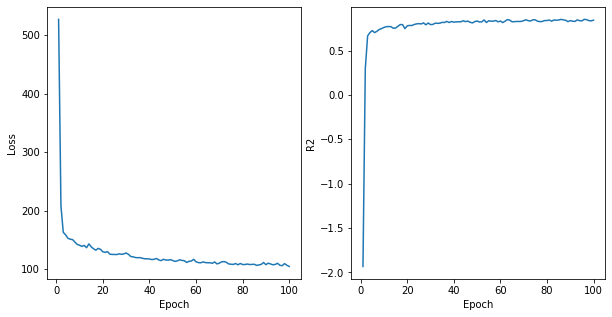

In [171]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(np.arange(1,101),loss_list)
plt.subplot(1,2,2)
plt.xlabel('Epoch')
plt.ylabel('R2')
plt.plot(np.arange(1,101), r2_list)
plt.show()